<a href="https://colab.research.google.com/github/sreejithvn/zero-shot-classification-for-long-text/blob/main/3_2_NLI_finetuned_BERT_MNLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
import time
import torch

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Help RESET the INDEX
df = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/MSC_Project/Jan2020Frontiers_20_labels.jsonl', lines=True)

In [ ]:
df.head()

,id,text,journal,label,clean_text
0,465950,\n Sleep Characteristics and Influencing Facto...,Frontiers in Medicine,Medicine,sleep characteristics and influencing factors ...
1,483526,A Hybrid Approach for Modeling Type 2 Diabetes...,Frontiers in Genetics,Genetics,a hybrid approach for modeling type diabetes m...
2,437333,Environmental Health Research in Africa: Impor...,Frontiers in Genetics,Genetics,environmental health research in africa: impor...
3,486515,"\n 3,5-T2—A Janus-Faced Thyroid Hormone Metabo...",Frontiers in Endocrinology,Endocrinology,",-—a janus-faced thyroid hormone metabolite ex..."
4,488364,\n Differential Regulation of LPS-Mediated VE-...,Frontiers in Cell and Developmental Biology,Cell and Developmental Biology,differential regulation of lps-mediated ve-cad...


## SPLITTING DATA into TRAIN, VALIDATION and TEST sets

In [ ]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df.clean_text, df.label, test_size=0.2, 
                                                                      random_state=42, stratify=df.label, shuffle=True)

In [ ]:
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, 
                                                                  random_state=42, stratify=temp_labels, shuffle=True)

In [ ]:
# reset_indices
train_texts.reset_index(drop=True, inplace=True), train_labels.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True), val_labels.reset_index(drop=True, inplace=True)
test_texts.reset_index(drop=True, inplace=True), test_labels.reset_index(drop=True, inplace=True)

(None, None)

In [ ]:
test_texts

0      respiratory morbidity and lung function analys...
1      flavor techniques for lfv processes: higgs dec...
2      corrigendum: human milk oligosaccharide compos...
3      obsessive–compulsive personality symptoms pred...
4      blood-brain barrier and delivery of protein an...
                             ...                        
106    synergies between division of labor and gut mi...
107    efficient and stable photocatalytic hydrogen e...
108    the δ-opioid receptor differentially regulates...
109    thalidomide in the treatment of sweet's syndro...
110    investigating gray and white matter structural...
Name: clean_text, Length: 111, dtype: object

In [ ]:
train_texts.shape, val_texts.shape, test_texts.shape

((880,), (110,), (111,))

In [ ]:
# Each set contains samples from all classes
len(train_labels.unique()), len(val_labels.unique()), len(test_labels.unique())

(20, 20, 20)

In [ ]:
pd.DataFrame([train_labels.value_counts(), val_labels.value_counts(), test_labels.value_counts()], 
             index=['Train', 'Val', 'Test']).T

,Train,Val,Test
Physiology,84,10,11
Genetics,79,10,10
Neuroscience,71,9,9
Psychiatry,69,8,9
Neurology,61,7,8
Chemistry,55,7,7
Marine Science,51,6,7
Bioengineering and Biotechnology,45,5,6
Endocrinology,42,5,6
Cell and Developmental Biology,38,5,4


# Define Model and Load to GPU 

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-MNLI", label2id={"entailment": 1,"neutral": 2,"contradiction": 0}).to(device) # https://github.com/QData/TextAttack/issues/684

Downloading:   0%|          | 0.00/630 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

## Import Tokenizer for NLI model

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-MNLI")

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from transformers import AdamW

# optimizer = AdamW(model.parameters(), lr=1e-3)  learning rate, lr = 1e-3, gave exact same accuracy of .509 for all epochs
optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Training Epochs
epochs = 10

# total_steps = len(train_loader) * epochs
total_steps = len(train_texts) * epochs


# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)


## Load Metrics

In [ ]:
import datasets
from datasets import load_metric

train_metric_accuracy = load_metric('accuracy')
val_metric_accuracy = load_metric('accuracy')
test_metric_accuracy = load_metric('accuracy')

train_metric_f1 = load_metric('f1', average='macro')
val_metric_f1 = load_metric('f1', average='macro')
test_metric_f1 = load_metric('f1', average='macro')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  after removing the cwd from sys.path.


In [ ]:
# torch.cuda.empty_cache()

# import gc
# # del variables
# gc.collect()

# torch.cuda.memory_summary(device=None, abbreviated=False)

# Training and Evaluating the Model

# Training Modified for NLI

In [ ]:
# encode labels using the default mapping used by other nli datasets
# i.e, entailment: 0, neutral: 1, contradiction: 2 -> entailment: 1, neutral: 2, contradiction: 0
# gold label for entailment set to 1
gold_label_id = 1
training_stats = []

# from transformers.tokenization_utils import TruncationStrategy

for epoch in range(epochs):

  start = time.perf_counter() 

  # Reset the total loss for this epoch.
  total_train_loss = 0

  model.train()  # switch to train mode

  for index, data in enumerate(train_texts):

    label = train_labels[index]
    start_time = time.perf_counter() 

    optimizer.zero_grad()   # Always clear any previously calculated gradients before performing a
                            # backward pass. PyTorch doesn't do this automatically because 
                            # accumulating the gradients is "convenient while training RNNs"

    premise = data
    hypothesis = f'This example is {label}.'

    results = tokenizer(premise, hypothesis, padding=True, truncation='only_first', return_token_type_ids=True, return_tensors='pt')

    input_ids = results['input_ids'].to(device)
    attention_mask = results['attention_mask'].to(device)
    token_type_ids = results['token_type_ids'].to(device)
    labels = torch.tensor(gold_label_id).to(device)

    loss, logits = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels, return_dict=False)
    
    # loss = outputs[0]  # Get computed loss

    total_train_loss += loss.item()

    loss.backward()    # compute gradients
    optimizer.step()   # update weights using above gradients (backpropogation)
    scheduler.step()   # update learning rate


    predictions = logits.argmax(dim=-1)
    # print(predictions)

    # Track model's performance using corresponding metric object

    train_metric_accuracy.add(predictions=predictions, 
                              references=labels)
    
    train_metric_f1.add(predictions=predictions, 
                        references=labels)

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_texts)
  print(f"epoch {epoch}: 'training loss':{avg_train_loss:.2f}")

  train_accuracy = train_metric_accuracy.compute()['accuracy']
  train_f1 = train_metric_f1.compute(average='macro')['f1']

  # stop_time = time.perf_counter() 
  # print('Train time for each batch:', stop_time - start_time)

  model.eval()  # switch to evaluation mode

  # Tracking evaluation metrics
  total_eval_loss = 0

  for index, data in enumerate(val_texts):

    label = val_labels[index]
    start_time = time.perf_counter() 

    results = tokenizer(premise, hypothesis, padding=True, truncation='only_first', return_token_type_ids=True, return_tensors='pt')

    input_ids = results['input_ids'].to(device)
    attention_mask = results['attention_mask'].to(device)
    token_type_ids = results['token_type_ids'].to(device)
    labels = torch.tensor(gold_label_id).to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training)
    # with torch.no_grad():   # But reports same accuracy scores for each epoch (<30%)

    loss, logits = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels, return_dict=False)
      
    ########## IS IT LOSS, logits for pair of sentencex!!!!!

    # Accumulate the validation loss
    total_eval_loss += loss.item()

    # print(f'logits for {label}: {logits}')

    predictions = logits.argmax(dim=-1)
    # print(predictions)

    # Track model's performance using corresponding metric object
    val_metric_accuracy.add(predictions=predictions, 
                              references=labels)
    
    val_metric_f1.add(predictions=predictions, 
                        references=labels)

    stop_time = time.perf_counter() 
    # print('Validation time each batch:', stop_time - start_time)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_texts)
  print(f"epoch {epoch}: 'validation Loss:':{avg_val_loss:.2f}")

  val_accuracy = val_metric_accuracy.compute()['accuracy']
  val_f1 = val_metric_f1.compute(average='macro')['f1']

  # Record all statistics from this epoch.
  training_stats.append({'epoch': epoch + 1, 
                         'Training Loss': avg_train_loss, 
                         'Validation Loss': avg_val_loss,
                         'Training Accuracy': train_accuracy,
                         'Training F1': train_f1,
                         'Validation Accuracy': val_accuracy,
                         'Validation F1': val_f1})


  print(f"epoch {epoch}: 'val_accuracy':{val_accuracy*100:.2f}")
  print(f"epoch {epoch}: 'val_f1_score':{val_f1*100:.2f}")
  print('')

  stop = time.perf_counter() 
  # print('Time taken for each Epoch: ', stop - start)


epoch 0: 'training loss':0.00
epoch 0: 'validation Loss:':0.00
epoch 0: 'val_accuracy':100.00
epoch 0: 'val_f1_score':100.00

epoch 1: 'training loss':0.00
epoch 1: 'validation Loss:':0.00
epoch 1: 'val_accuracy':100.00
epoch 1: 'val_f1_score':100.00

epoch 2: 'training loss':0.00
epoch 2: 'validation Loss:':0.00
epoch 2: 'val_accuracy':100.00
epoch 2: 'val_f1_score':100.00

epoch 3: 'training loss':0.00
epoch 3: 'validation Loss:':0.00
epoch 3: 'val_accuracy':100.00
epoch 3: 'val_f1_score':100.00

epoch 4: 'training loss':0.00
epoch 4: 'validation Loss:':0.00
epoch 4: 'val_accuracy':100.00
epoch 4: 'val_f1_score':100.00

epoch 5: 'training loss':0.00
epoch 5: 'validation Loss:':0.00
epoch 5: 'val_accuracy':100.00
epoch 5: 'val_f1_score':100.00

epoch 6: 'training loss':0.00
epoch 6: 'validation Loss:':0.00
epoch 6: 'val_accuracy':100.00
epoch 6: 'val_f1_score':100.00

epoch 7: 'training loss':0.00
epoch 7: 'validation Loss:':0.00
epoch 7: 'val_accuracy':100.00
epoch 7: 'val_f1_score':

In [ ]:
stats_df = pd.DataFrame(training_stats)
stats_df

,epoch,Training Loss,Validation Loss,Training Accuracy,Training F1,Validation Accuracy,Validation F1
0,1,0.001211,0.000043,1.0,1.0,1.0,1.0
1,2,0.000041,0.000018,1.0,1.0,1.0,1.0
2,3,0.000020,0.000010,1.0,1.0,1.0,1.0
3,4,0.000012,0.000006,1.0,1.0,1.0,1.0
4,5,0.000008,0.000004,1.0,1.0,1.0,1.0
5,6,0.000006,0.000003,1.0,1.0,1.0,1.0
6,7,0.000004,0.000003,1.0,1.0,1.0,1.0
7,8,0.000003,0.000002,1.0,1.0,1.0,1.0
8,9,0.000003,0.000002,1.0,1.0,1.0,1.0
9,10,0.000003,0.000002,1.0,1.0,1.0,1.0


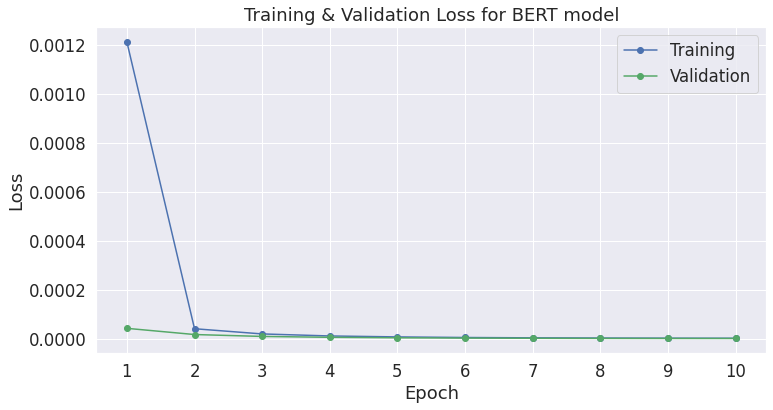

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_df['Training Loss'], 'b-o', label="Training")
plt.plot(stats_df['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss for BERT model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))

plt.show()

# Preparing Data for Testing

In [ ]:
candidate_labels = df.label.unique()
print(candidate_labels)

['Medicine' 'Genetics' 'Endocrinology' 'Cell and Developmental Biology'
 'Psychiatry' 'Public Health' 'Ecology and Evolution' 'Chemistry'
 'Physiology' 'Marine Science' 'Neurology'
 'Bioengineering and Biotechnology' 'Earth Science' 'Physics'
 'Cellular Neuroscience' 'Neuroscience' 'Veterinary Science'
 'Aging Neuroscience' 'Pediatrics' 'Cellular and Infection Microbiology']


# Testing the model

In [ ]:
def split_sequence(sequence):
  tokens = tokenizer.tokenize(sequence)
  chunks = [tokens[x:x+256] for x in range(0, len(tokens), 256)]
  return [' '.join(x).replace('##', '') for x in chunks]

In [ ]:
model.save_pretrained('/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model')

In [ ]:
tokenizer.save_pretrained('/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model')

('/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model/tokenizer_config.json',
 '/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model/special_tokens_map.json',
 '/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model/vocab.txt',
 '/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model/added_tokens.json',
 '/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model/tokenizer.json')

In [ ]:
from transformers import pipeline

classifier_gpu = pipeline("zero-shot-classification", device=0, model="/content/gdrive/MyDrive/nli_finetuned_bert_mnli_model")

In [ ]:
test_data_split = test_texts.apply(split_sequence)

Token indices sequence length is longer than the specified maximum sequence length for this model (5846 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
pd.DataFrame(test_data_split)

,clean_text
0,[respiratory mor bid ity and lung function ana...
1,[flavor techniques for l f v processes : hi gg...
2,[co rri gen du m : human milk ol igo sa cc har...
3,[ob ses sive – com pu ls ive personality sympt...
4,[blood - brain barrier and delivery of protein...
...,...
106,[syn er gies between division of labor and gut...
107,[efficient and stable photo cat aly tic hydrog...
108,[the δ - op io id receptor differential ly reg...
109,[tha lid omi de in the treatment of sweet ' s ...


In [ ]:
# Classifier only considers FIRST 512 (sentence) of each TEST sample (not split)  (2 min runtime)

test_sequences = list(test_texts)    # NOT SPLIT TEST DATA

candidate_labels = list(df.label.unique())

results = classifier_gpu(test_sequences, candidate_labels, batch_size=64) # Sequence is a list of list of sentences, but classifier only takes first sentence from inner list
# print(results)

scores_df = pd.DataFrame(results, columns=['labels', 'scores'])

In [ ]:
pred_labels_512 = scores_df['labels'].apply(lambda x: x[0])

In [ ]:
# For Entire long_text samples with default batch_size=64

candidate_labels = list(df.label.unique())

pred_labels_count_list = []
pred_labels_prob_list = []


start = time.perf_counter()

for ix, long_text in enumerate(test_data_split):

  start_time = time.perf_counter()

  print(f'Sample {ix}: True Label: {test_labels[ix]}')

  prob_score_dict = dict.fromkeys(candidate_labels, 0)

  result = classifier_gpu(long_text, candidate_labels, batch_size=64)
  
  for index in range(len(long_text)):
    # Create a temporary dict for storing probability scores corresponding to each label, for each chunk
    prob_score_chunk = dict(zip(result[index]['labels'], result[index]['scores']))
    for label in prob_score_dict:
      # Add and update probability score received for each chunk, to get overall score for the entire text sample
      prob_score_dict[label] += prob_score_chunk[label]

  max_prob_label = max(prob_score_dict, key=prob_score_dict.get)

  print('Predicted label based on highest probabilty score:', max_prob_label)
  
  score_df = pd.DataFrame(result, columns=['labels', 'scores'])

  # Get the labels with highest score(one at index '0') (for each sub-sentence)
  # Then get the label occuring first, the most time (chosen as the label for the main sentence)
  most_count_label = score_df['labels'].apply(lambda x: x[0]).value_counts().index[0] 
  
  print('Predicted label based on most first occurence count:', most_count_label)
  
  pred_labels_count_list.append(most_count_label)
  pred_labels_prob_list.append(max_prob_label)

  stop_time = time.perf_counter() 
  # print(f'Run time for sample {ix}: {(stop_time - start_time):.2f}')

stop = time.perf_counter()
runtime = stop-start
# print(f'Total run time: {runtime:.2f}')

Sample 0: True Label: Pediatrics
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Medicine
Sample 1: True Label: Physics
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Physics
Sample 2: True Label: Pediatrics
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Physiology
Sample 3: True Label: Psychiatry
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Psychiatry
Sample 4: True Label: Aging Neuroscience
Predicted label based on highest probabilty score: Physiology
Predicted label based on most first occurence count: Medicine
Sample 5: True Label: Pediatrics
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Physiology
Sample 6: True Label: Neuroscience
Predicted label ba

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Medicine
Sample 10: True Label: Genetics
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Physiology
Sample 11: True Label: Marine Science
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Chemistry
Sample 12: True Label: Neuroscience
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Neurology
Sample 13: True Label: Physiology
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Physiology
Sample 14: True Label: Public Health
Predicted label based on highest probabilty score: Neurology
Predicted label based on most first occurence count: Medicine
Sample 15: True Label: Marine Science
Predicted label based on highest probabil

# Accuracy and F1 Score results for TEST Data

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Results for TEST Dataset with only first 512
accuracy_test_data_512 = accuracy_score(test_labels, pred_labels_512)
f1_score_test_data_512 = f1_score(test_labels, pred_labels_512, average='macro')
print(f'Test data only first 512 -> Accuracy: {accuracy_test_data_512*100:.2f}, F1_score: {f1_score_test_data_512*100:.2f}')


# pred_labels_count_list  # For ENTIRE long_text DATA
accuracy_count = accuracy_score(test_labels, pred_labels_count_list)
f1_score_count = f1_score(test_labels, pred_labels_count_list, average='macro')
print(f'Test data long text (most first position count) -> Accuracy: {accuracy_count*100:.2f}, F1_score: {f1_score_count*100:.2f}')


# pred_labels_count_list  # For ENTIRE long_text DATA

accuracy_prob = accuracy_score(test_labels, pred_labels_prob_list)
f1_score_prob = f1_score(test_labels, pred_labels_prob_list, average='macro')
print(f'Test data long text (highest probability sum) -> Accuracy: {accuracy_prob*100:.2f}, F1_score: {f1_score_prob*100:.2f}')

Test data only first 512 -> Accuracy: 17.12, F1_score: 13.91
Test data long text (most first position count) -> Accuracy: 31.53, F1_score: 23.74
Test data long text (highest probability sum) -> Accuracy: 14.41, F1_score: 12.23


In [ ]:
few_shot_metrics_table_df_new_label2id = pd.DataFrame(data=([np.round(accuracy_test_data_512*100,2),
                    np.round(f1_score_test_data_512*100,2)],
                   [np.round(accuracy_count*100,2),
                    np.round(f1_score_count*100,2)],
                   [np.round(accuracy_prob*100,2),
                    np.round(f1_score_prob*100,2)]), 
                    columns=['Accuracy', 'F1_score'], 
                    index=['Only first 512', 'Long text (most first position count)', 'Long text (highest probability sum)'])

few_shot_metrics_table_df_new_label2id

,Accuracy,F1_score
Only first 512,17.12,13.91
Long text (most first position count),31.53,23.74
Long text (highest probability sum),14.41,12.23
